In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image
import cPickle as pkl
import time
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
import glob
%matplotlib inline  
print ("Packages loaded")

Packages loaded


# Load dataset

In [2]:
dirpath = "./data/iccv09Data/images/"
height = 240
width  = 320
resize_ratio = 3
nr_img = 0
fileList = glob.glob(dirpath + '*.jpg')
for i, file in enumerate(fileList):
    img = Image.open(file)
    array = np.array(img) 
    if array.shape[0] == height and array.shape[1] == width:
        nr_img = nr_img + 1
        rgb = array.reshape(1, height, width, 3)
        imglow = img.resize((int(width/resize_ratio)
                ,int(height/resize_ratio)), Image.BICUBIC)
        imglow = imglow.resize((width, height), Image.BICUBIC)
        rgblow = np.array(np.float32(imglow)/255.)
        rgblow = rgblow.reshape(1, height, width, 3)
        rgb = np.reshape(rgb, [1, -1])
        rgblow = np.reshape(rgblow, [1, -1])
        if nr_img == 1:
            data = rgb
            datalow = rgblow
        else:
            data = np.concatenate((data, rgb), axis=0)
            datalow = np.concatenate((datalow, rgblow), axis=0)
        
print ("nr_img is %d" % (nr_img))
print ("Shape of 'data' is %s" % (data.shape,))
print ("Shape of 'datalow' is %s" % (datalow.shape,))

nr_img is 531
Shape of 'data' is (531, 230400)
Shape of 'datalow' is (531, 230400)


# Divide into two sets
## (xtrain, ytrain) and (xtest, ytest)

In [3]:
randidx = np.random.permutation(nr_img)
nrtrain = int(nr_img*0.7)
nrtest  = nr_img - nrtrain
xtrain  = datalow[randidx[0:nrtrain], :]
ytrain  = data[randidx[0:nrtrain], :]
xtest   = datalow[randidx[nrtrain:nr_img], :]
ytest   = data[randidx[nrtrain:nr_img], :]
print ("Shape of 'xtrain' is %s" % (xtrain.shape,))
print ("Shape of 'ytrain' is %s" % (ytrain.shape,))
print ("Shape of 'xtest' is %s" % (xtest.shape,))
print ("Shape of 'ytest' is %s" % (ytest.shape,))

Shape of 'xtrain' is (371, 230400)
Shape of 'ytrain' is (371, 230400)
Shape of 'xtest' is (160, 230400)
Shape of 'ytest' is (160, 230400)


# Plot some images

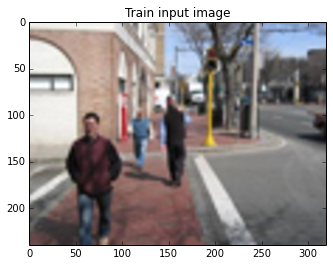

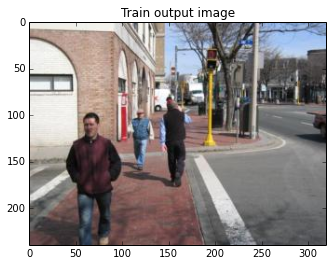

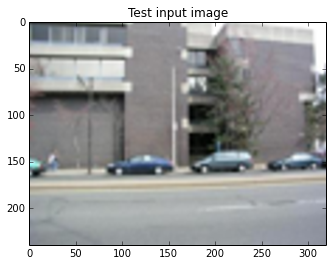

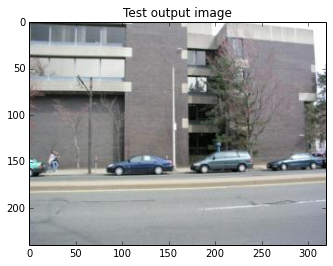

In [4]:
# Train
randidx = np.random.randint(nrtrain)
currx = xtrain[randidx, :]
currx = np.reshape(currx, [height, width, 3])
plt.imshow(currx)
plt.title("Train input image")
plt.show()
curry = ytrain[randidx, :]
curry = np.reshape(curry, [height, width, 3])
plt.imshow(curry)
plt.title("Train output image")
plt.show() 
# Test
randidx = np.random.randint(nrtest)
currx = xtest[randidx, :]
currx = np.reshape(currx, [height, width, 3])
plt.imshow(currx)
plt.title("Test input image")
plt.show()
curry = ytest[randidx, :]
curry = np.reshape(curry, [height, width, 3])
plt.imshow(curry)
plt.title("Test output image")
plt.show()

# Define network

In [5]:
n1 = 32
n2 = 64
n3 = 64
n4 = 64
n5 = 64
n6 = 3
ksize = 3
weights = {
    'ce1': tf.Variable(tf.random_normal([ksize, ksize, 3, n1],  stddev=0.01)),
    'ce2': tf.Variable(tf.random_normal([ksize, ksize, n1, n2], stddev=0.01)),
    'ce3': tf.Variable(tf.random_normal([ksize, ksize, n2, n3], stddev=0.01)),
    'ce4': tf.Variable(tf.random_normal([ksize, ksize, n3, n4], stddev=0.01)),
    'ce5': tf.Variable(tf.random_normal([ksize, ksize, n4, n5], stddev=0.01)),
    'ce6': tf.Variable(tf.random_normal([ksize, ksize, n5, n6],  stddev=0.01))
}
biases = {
    'be1': tf.Variable(tf.random_normal([n1], stddev=0.01)),
    'be2': tf.Variable(tf.random_normal([n2], stddev=0.01)),
    'be3': tf.Variable(tf.random_normal([n3], stddev=0.01)),
    'be4': tf.Variable(tf.random_normal([n4], stddev=0.01)),
    'be5': tf.Variable(tf.random_normal([n5], stddev=0.01)),
    'be6': tf.Variable(tf.random_normal([n6], stddev=0.01))
}
def srn(_X, _W, _b, _keepprob):
    _input_r = tf.reshape(_X, shape=[-1, height, width, 3])
    # Encoder
    _ce1 = tf.nn.relu(tf.add(tf.nn.conv2d(_input_r, _W['ce1']
        , strides=[1, 1, 1, 1], padding='SAME'), _b['be1']))
    _ce1 = tf.nn.dropout(_ce1, _keepprob)
    _ce2 = tf.nn.relu(tf.add(tf.nn.conv2d(_ce1, _W['ce2']
        , strides=[1, 1, 1, 1], padding='SAME'), _b['be2'])) 
    _ce2 = tf.nn.dropout(_ce2, _keepprob)
    _ce3 = tf.nn.relu(tf.add(tf.nn.conv2d(_ce2, _W['ce3']
        , strides=[1, 1, 1, 1], padding='SAME'), _b['be3'])) 
    _ce3 = tf.nn.dropout(_ce3, _keepprob)
    
    _ce4 = tf.nn.relu(tf.add(tf.nn.conv2d(_ce3, _W['ce4']
        , strides=[1, 1, 1, 1], padding='SAME'), _b['be4']))
    _ce4 = tf.nn.dropout(_ce4, _keepprob)
    _ce5 = tf.nn.relu(tf.add(tf.nn.conv2d(_ce4, _W['ce5']
        , strides=[1, 1, 1, 1], padding='SAME'), _b['be5'])) 
    _ce5 = tf.nn.dropout(_ce5, _keepprob)
    _ce6 = tf.nn.relu(tf.add(tf.nn.conv2d(_ce5, _W['ce6']
        , strides=[1, 1, 1, 1], padding='SAME'), _b['be6'])) 
    _out = _ce6 + _input_r
    return {'input_r': _input_r, 'ce1': _ce1, 'ce2': _ce2, 'ce3': _ce3
        , 'ce4': _ce4, 'ce5': _ce5, 'ce6': _ce6
        , 'layers': (_input_r, _ce1, _ce2, _ce3, _ce4, _ce5, _ce6)
        , 'out': _out}
print ("Network ready")

Network ready


# Define functions

In [6]:
dim = height*width*3
x = tf.placeholder(tf.float32, [None, dim])
y = tf.placeholder(tf.float32, [None, dim])
keepprob = tf.placeholder(tf.float32)
pred = srn(x, weights, biases, keepprob)['out']
cost = tf.reduce_mean(tf.square(srn(x, weights, biases, keepprob)['out'] 
            - tf.reshape(y, shape=[-1, height, width, 3])))
learning_rate = 0.001
optm = tf.train.AdamOptimizer(learning_rate, 0.9).minimize(cost)
init = tf.initialize_all_variables()
print ("Functions ready")

Functions ready


# Run

In [7]:
sess = tf.Session()
sess.run(init)
# Fit all training data
batch_size = 16
n_epochs   = 100000
print("Strart training..")
for epoch_i in range(n_epochs):
    for batch_i in range(nrtrain // batch_size):
        randidx = np.random.randint(nrtrain, size=batch_size)
        batch_xs = xtrain[randidx, :]
        batch_ys = ytrain[randidx, :]
        sess.run(optm, feed_dict={x: batch_xs
            , y: batch_ys, keepprob: 0.7})
    if (epoch_i % 10) == 0:
        print ("[%02d/%02d] cost: %.4f" % (epoch_i, n_epochs
            , sess.run(cost, feed_dict={x: batch_xs
            , y: batch_ys, keepprob: 1.})))
    if (epoch_i % 100) == 0:
        n_examples = 2
        print ("Training dataset")
        randidx = np.random.randint(nrtrain, size=n_examples)
        train_xs = xtrain[randidx, :]
        train_ys = ytrain[randidx, :]
        recon = sess.run(pred, feed_dict={x: train_xs, keepprob: 1.})
        fig, axs = plt.subplots(3, n_examples, figsize=(15, 20))
        for example_i in range(n_examples):
            axs[0][example_i].imshow(np.reshape(
                train_xs[example_i, :], (height, width, 3)))
            axs[1][example_i].imshow(np.reshape(
                recon[example_i, :], (height, width, 3)))
            axs[2][example_i].imshow(np.reshape(
                train_ys[example_i, :], (height, width, 3)))
        plt.show()
        print ("Test dataset")
        randidx = np.random.randint(nrtest, size=n_examples)
        test_xs = xtest[randidx, :]
        test_ys = ytest[randidx, :]
        recon = sess.run(pred, feed_dict={x: test_xs, keepprob: 1.})
        fig, axs = plt.subplots(3, n_examples, figsize=(15, 20))
        for example_i in range(n_examples):
            axs[0][example_i].imshow(np.reshape(
                test_xs[example_i, :], (height, width, 3)))
            axs[1][example_i].imshow(np.reshape(
                recon[example_i, :], (height, width, 3)))
            axs[2][example_i].imshow(np.reshape(
                test_ys[example_i, :], (height, width, 3)))
        plt.show()
print("Training done. ")    

Strart training..


ResourceExhaustedError: OOM when allocating tensor with shape[32,240,320,3]
	 [[Node: Conv2D_11 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](dropout_9/mul_1, Variable_5/read)]]
Caused by op u'Conv2D_11', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-d55d1738db19>", line 6, in <module>
    cost = tf.reduce_mean(tf.square(srn(x, weights, biases, keepprob)['out']
  File "<ipython-input-5-2c90c7df4799>", line 44, in srn
    , strides=[1, 1, 1, 1], padding='SAME'), _b['be6']))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 295, in conv2d
    data_format=data_format, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/op_def_library.py", line 683, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2154, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1154, in __init__
    self._traceback = _extract_stack()
